In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from algbench import read_as_pandas
import re

font = {'family': 'serif', 'size': 11}
matplotlib.rc('font', **font)

sns.set_theme()

"""
QTG: #089099 - PPQAgreen
QTG non-biased: #7CCBA2 - PPQAlightgreen
Grover:#F0746E - PPQAorange
Nested Q Search:#DC3977 - PPQApink
QBnB:#7C1D6F - PPQApurple

Classical Methods:
Combo:# - PPQAbrown
CTG:#045275 - PPQAblue
IP:#27AE60
CP-sat:#9B59B6
greedy:#CB4335
"""

matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=[
    "#6E2C00",
    "#27AE60",
    "#9B59B6",
    "#CB4335",
    "#089099",
    "#7C1D6F",
    "#045275",
    #"#ffffff",
]) 

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = [9, 3.5]

In [2]:
algorithm_mapping = {
    "combo": "COMBO",
    "cp-sat": "CP-SAT",
    "expknap": "Expknap",
    "greedy": "Greedy",
    "ip": "IP",
    "qtg": "QTG"
}
hue_order = [
    algorithm_mapping["combo"],
    algorithm_mapping["ip"],
    algorithm_mapping["cp-sat"],
    algorithm_mapping["greedy"],
    algorithm_mapping["qtg"]
]

qbnb_mapping = {
    "ambainis": "QBnB LB", #"QBnB Amb LB",
    "montanaro": "QBnB Mon LB"
}

In [3]:
memory_baseline = {
    alg: 0 for alg in algorithm_mapping.keys()
}

memory_baseline_results = read_as_pandas('results/classical_benchmark/memory_baseline', lambda row: {
    'algorithm': row['parameters']['args']['solver'],
    'memory_kb': row['result']['maximum_resident_size_kb'],
}).groupby(['algorithm']).describe()

for alg in algorithm_mapping:
    if alg == "qtg": continue
    memory_baseline[alg] = memory_baseline_results['memory_kb']['min'][alg]

print(memory_baseline)

{'combo': 83432.0, 'cp-sat': 88632.0, 'expknap': 83464.0, 'greedy': 83392.0, 'ip': 88588.0, 'qtg': 0}


In [4]:
paths = ['classical_qtg_comparison/small', 'classical_qtg_comparison/large']

classical_results = pd.concat([read_as_pandas(f'results/classical_benchmark/{path}', lambda row: {
    'algorithm': row['parameters']['args']['solver'],
    'algorithm_human_readable': algorithm_mapping[row['parameters']['args']['solver']],
    'size': row['parameters']['args']['instance']['size'],
    'elapsed_cycles': row['result']['elapsed_cycles'] if 'elapsed_cycles' in row['result'] else -1,
    'instance': row['parameters']['args']['instance']['name'],
    'objective_value': row['result']['objective_value'],
    'memory_bits': (row['result']['maximum_resident_size_kb'] - memory_baseline[
        row['parameters']['args']['solver']]) * 1024 * 8,  # to bytes -> to bits
}) for path in paths], ignore_index=True)

optimal_solutions = dict()
for i, row in classical_results[classical_results['algorithm'] == "combo"].iterrows():
    optimal_solutions[row['instance']] = row['objective_value']


qtg_results = pd.concat([read_as_pandas(f'results/quantum_benchmark/{path}', lambda row: {
    'algorithm': 'qtg',
    'algorithm_human_readable': algorithm_mapping["qtg"],
    'size': row['parameters']['args']['instance']['size'],
    'elapsed_cycles': np.average([measure['cycle_count'] for measure in row['result']['measurements']]),
    'memory_bits': np.average([measure['qubit_count'] for measure in row['result']['measurements']]),
    'average_gap': np.average([
        (optimal_solutions[row['parameters']['args']['instance']['name']] -
         measure['objective_value']) / optimal_solutions[row['parameters']['args']['instance']['name']]
        for measure in row['result']['measurements']]),
    'best_gap': np.min([
        (optimal_solutions[row['parameters']['args']['instance']['name']] -
         measure['objective_value']) / optimal_solutions[row['parameters']['args']['instance']['name']]
        for measure in row['result']['measurements']]),
    'success_probability': sum([1 for measure in row['result']['measurements'] if
                                measure['objective_value'] == optimal_solutions[
                                    row['parameters']['args']['instance']['name']]]) / len(
        row['result']['measurements']),
    'instance': row['parameters']['args']['instance']['name']
}) for path in paths], ignore_index=True)

qbnb_results = pd.concat([read_as_pandas(f'results/qbnb/{path}', lambda row: {
    'algorithm': row['parameters']['args']['alg_params']['algorithm'],
    'algorithm_human_readable': qbnb_mapping[row['parameters']['args']['alg_params']['algorithm']],
    'elapsed_cycles_lb': row['result']['elapsed_cycles_lb'],
    'size': row['parameters']['args']['instance']['size'],
    'instance': row['parameters']['args']['instance']['name']
}) for path in paths], ignore_index=True)

ctg_results = pd.concat([read_as_pandas(f'results/ctg/{path}', lambda row: {
    'algorithm': 'ctg',
    'algorithm_human_readable': 'CTG',
    'elapsed_cycles': np.average(row['result']['elapsed_cycles']),
    'success_probability': sum([1 for obj in row['result']['objective_values'] if
                                obj == optimal_solutions[row['parameters']['args']['instance']['name']]]) / len(
        row['result']['objective_values']),
    'size': row['parameters']['args']['instance']['size'],
    'instance': row['parameters']['args']['instance']['name'],
    'qtg_estimate_cycles': np.average(
        [it * row['result']['qtg_cycles'] for it in row['result']['total_iterations']]),
    'qtg_estimate_memory_bits': row['parameters']['args']['instance']['size'] +
                                np.log2(row['parameters']['args']['instance']['capacity']) +
                                np.log2(optimal_solutions[row['parameters']['args']['instance']['name']]) +
                                max(row['parameters']['args']['instance']['size'],
                                    np.log2(row['parameters']['args']['instance']['capacity']),
                                    np.log2(optimal_solutions[row['parameters']['args']['instance']['name']])
                                    ) + 1,
}) for path in paths if os.path.isdir(f'results/ctg/{path}/results')], ignore_index=True)

def g_group(row):
    if row['g'] == 2:
        return "$g=2$"
    elif row['g'] > 2 and row['g'] <= 6:
        return "$3 \\leq g \\leq 6$"
    return "$7 \\leq g \\leq 10$"

for df in [classical_results, qtg_results, qbnb_results, ctg_results]:
    df['g'] = df.apply(lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)
    df['g_group'] = df.apply(g_group, axis=1)

In [14]:
print(len(classical_results['instance'].unique()))

648


['COMBO', 'IP', 'CP-SAT', 'Greedy', 'QTG', 'QBnB LB', 'CTG']


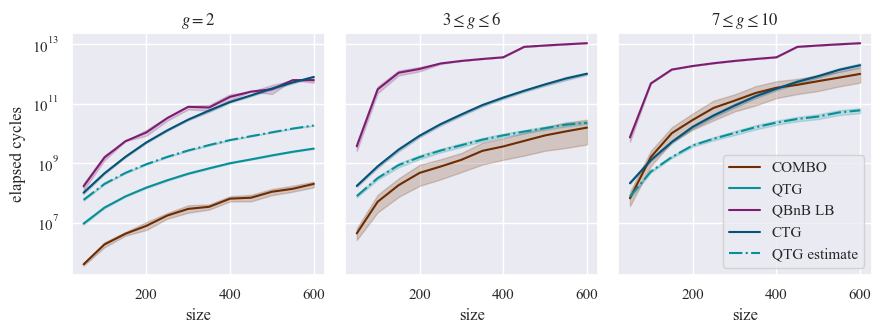

In [5]:
qbnb_results_cpy = qbnb_results.copy()
qbnb_results_cpy['elapsed_cycles'] = qbnb_results_cpy['elapsed_cycles_lb']
elapsed_cycles_comparison = pd.concat([
    classical_results[classical_results['algorithm'] == "combo"],
    qtg_results,
    ctg_results,
    qbnb_results_cpy[qbnb_results_cpy['algorithm'] == "ambainis"]
])

elapsed_cycles_comparison["algorithm"] = elapsed_cycles_comparison["algorithm_human_readable"]

fig, axs = plt.subplots(figsize=(9, 3.5), ncols=3)

elapsed_cycles_hue_order = list(hue_order)
elapsed_cycles_hue_order.append(qbnb_mapping["ambainis"])
#elapsed_cycles_hue_order.append(qbnb_mapping["montanaro"])
elapsed_cycles_hue_order.append("CTG")

print(elapsed_cycles_hue_order)
for i, val in enumerate(['$g=2$', '$3 \\leq g \\leq 6$', '$7 \\leq g \\leq 10$']):
    sns.lineplot(elapsed_cycles_comparison[elapsed_cycles_comparison['g_group'] == val],
                 x='size', y='elapsed_cycles',
                 hue='algorithm', hue_order=elapsed_cycles_hue_order, ax=axs[i])

    sns.lineplot(elapsed_cycles_comparison[
                     (elapsed_cycles_comparison['g_group'] == val) &
                     (elapsed_cycles_comparison['algorithm'] == "CTG")
                     ],
                 x='size', y='qtg_estimate_cycles', ax=axs[i], label="QTG estimate", linestyle='-.', color="C4")

    axs[i].set_title(val)

    axs[i].set_yscale('log')
    axs[i].set_ylabel("elapsed cycles")
    legend = axs[i].legend()
    texts = [algo.get_text() for algo in legend.get_texts()]
    lines = legend.get_lines()
    legend.remove()

min_y = min([ax.get_ylim()[0] for ax in axs])
max_y = max([ax.get_ylim()[1] for ax in axs])

for i, ax in enumerate(axs):
    ax.set_ylim(min_y, max_y)
    if i > 0:
        ax.set_yticklabels([])
        ax.set_ylabel("")

axs[-1].legend(lines[0:1] + lines[4:], texts[0:1] + texts[4:], loc='best', ncol=1)

fig.tight_layout()
fig.savefig('out/06_elapsed_cycles.pdf', bbox_inches='tight')
#_ = ax.legend(lines[0:1] + lines[4:], texts[0:1] + texts[4:], loc='upper left')

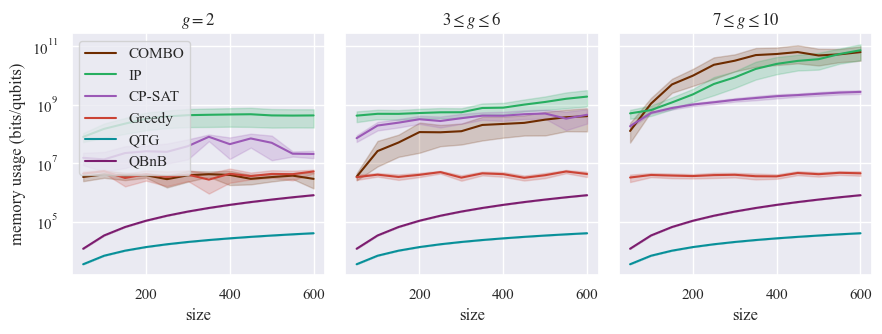

In [17]:
qbnb = qtg_results.copy()
qbnb['memory_bits'] = qbnb.apply(lambda row: row["memory_bits"] * row["size"], axis=1)
qbnb['algorithm_human_readable'] = "QBnB"

ctg = ctg_results.copy()
ctg['memory_bits'] = ctg['qtg_estimate_memory_bits']

memory_comparison = pd.concat([
    classical_results[classical_results["algorithm"] != "expknap"],
])

def add_classical_memory(row):
    size = row["size"]
    size_int = 32 
    return row["memory_bits"] + 2 * size_int + size * 2 * size_int # capacity + size + n * (costs+profits)
    

qbnb['memory_bits'] = qbnb.apply(add_classical_memory, axis=1)
ctg['memory_bits'] = ctg.apply(add_classical_memory, axis=1)

fig, axs = plt.subplots(figsize=(9, 3.5), ncols=3)
for i, val in enumerate(['$g=2$', '$3 \\leq g \\leq 6$', '$7 \\leq g \\leq 10$']):
    sns.lineplot(memory_comparison[memory_comparison['g_group'] == val], 
                 x='size', y='memory_bits', 
                 hue='algorithm_human_readable', hue_order=hue_order, ax=axs[i])
    sns.lineplot(ctg[ctg['g_group'] == val], x='size', y='memory_bits', ax=axs[i], color="C4")
    sns.lineplot(qbnb, x='size', y='memory_bits', ax=axs[i], color="C5", label="QBnB")
    axs[i].set_yscale('log')
    axs[i].set_title(val)
    
    legend = axs[i].legend(loc="upper left")
    texts = [algo.get_text() for algo in legend.get_texts()]
    lines = legend.get_lines()
    legend.remove()

    if i == 0:
        axs[i].set_ylabel("memory usage (bits/qubits)")
    else:
        axs[i].set_ylabel("")

axs[0].legend(lines, texts, loc='upper left', ncol=1)
fig.subplots_adjust(top=0.8)
min_y = min([ax.get_ylim()[0] for ax in axs])
max_y = max([ax.get_ylim()[1] for ax in axs])

for i, ax in enumerate(axs):
    ax.set_ylim(min_y, max_y)
    if i > 0:
        ax.set_yticklabels([])
        ax.set_ylabel("")
        
fig.tight_layout()
fig.savefig('out/06_memory_comparison_with_classical.pdf', bbox_inches='tight')

In [8]:
memory_comparison[memory_comparison["algorithm"] == "combo"]["memory_bits"]

8       1245184.0
10      4915200.0
11      1933312.0
14      1441792.0
18      4915200.0
          ...    
4537    1998848.0
4542    3866624.0
4544    3670016.0
4545    1441792.0
4558    3440640.0
Name: memory_bits, Length: 912, dtype: float64

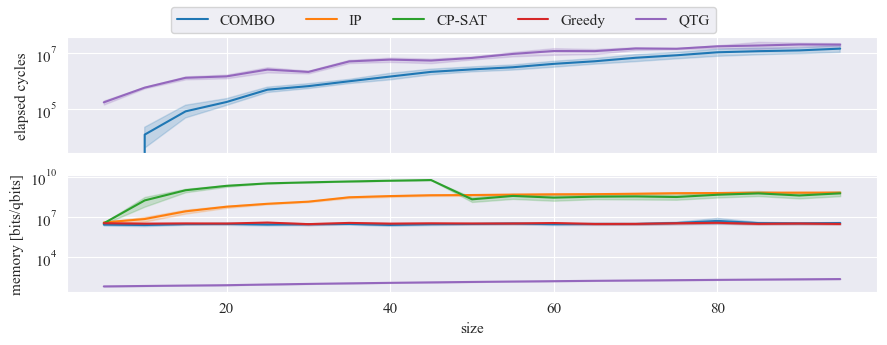

In [9]:
fig, axs = plt.subplots(nrows=2)
ax = axs[0]
sns.lineplot(elapsed_cycles_comparison, x='size', y='elapsed_cycles', hue='algorithm_human_readable',
             hue_order=hue_order, ax=ax)
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_yscale('log')
ax.set_ylabel("elapsed cycles")

ax = axs[1]
sns.lineplot(memory_comparison, x='size', y='memory_bits', hue='algorithm_human_readable', hue_order=hue_order, ax=ax)
ax.set_yscale('log')
ax.set_ylabel("memory [bits/qbits]")

legend = fig.legend()
texts = [algo.get_text() for algo in legend.get_texts()]
lines = legend.get_lines()
legend.remove()

fig.legend(lines[:len(hue_order)], texts[:len(hue_order)], loc='upper center', ncol=5)

axs[0].legend().remove()
axs[1].legend().remove()

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.savefig('out/05_qtg_cycles_memory.pdf', bbox_inches='tight')

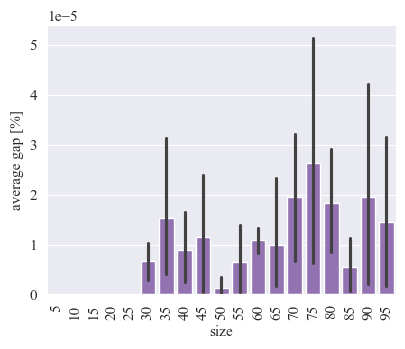

In [10]:
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.barplot(qtg_results, x='size', y='average_gap', ax=ax, color='C4')
ax.set_ylabel("average gap [%]")
ax.set_xticks(list(range(len(qtg_results['size'].unique()))))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

#ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))

fig.savefig("out/05_qtg_average_gap.pdf", bbox_inches='tight')